In [94]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/cucchi/phd/devel/phd/')

import os
import xarray as xr
import math
import numpy as np
import matplotlib.pyplot as plt

from lab import analysis
from lab.simulation import forcings

REF_RESP_PATH = [
    '/home/cucchi/phd/data/response/lorenz96/rk4/SF_8_1.0_0/',
    '/home/cucchi/phd/data/response/lorenz96/rk4/SF_8_-1.0_0/'            
]

SAVE_PLOT = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Observation

In [95]:
observation = 'position'

QUANTILES_PATH = '/home/cucchi/phd/data/obs/lorenz96/rk4/CF_8/quantiles/obs_lorenz96_rk4_CF_8_quantiles_{}.nc'.format(
    observation
)

### Linear Forcing

In [96]:
force_linear_coefficient = 0.01
deactivation_time = 100

forcing = 'LF_8_{}_0_{}'.format(force_linear_coefficient, deactivation_time)
forcing_obj = forcings.LinearForcing(
    linear_coefficient=force_linear_coefficient,
    deactivation_time=deactivation_time
)

### Step Forcing

In [ ]:
force_intensity_delta = 1.0

forcing = 'SF_8_{}_0'.format(force_intensity_delta)
forcing_obj = forcings.StepForcing(
    force_intensity_delta=force_intensity_delta
)

### Sinusoidal Forcing

In [ ]:
epsilon = 1.0
omega = 0.1
deactivation_time = 100

forcing = 'SinF_8_{}_{}_0_{}'.format(epsilon, omega, deactivation_time)
forcing_obj = forcings.SinusoidalForcing(
    epsilon=epsilon,
    omega=omega,
    deactivation_time=deactivation_time
)

## Multiple Plots

### Bins

In [ ]:
obs_all = ['{}_bin_{}q_{}q'.format(observation, 
                                   str(np.round(quant, 1)), 
                                   str(np.round(quant + 0.1, 1))) for quant in np.arange(0, 0.9, 0.1)]
obs_all.append('{}_exceed_0.9q'.format(observation))

Compute **susceptibilities**

In [ ]:
chi_semidiff = {}
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], 'response_lorenz96_rk4_{}_SF_8_1.0_0.nc'.format(obs)))
    response_m1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[1], 'response_lorenz96_rk4_{}_SF_8_-1.0_0.nc'.format(obs)))
    response_semidiff = (response_p1 - response_m1)/2
    chi_semidiff[obs] = analysis.compute_susceptibility(response_semidiff.values.squeeze())
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())

Compute **predicted responses**

In [ ]:
resp_real = {}
resp_pred_semidiff = {}
resp_pred_normal = {}
for obs in obs_all:
    resp_real[obs] = xr.open_dataarray(
        '/home/cucchi/phd/data/response/lorenz96/rk4/{f}/response_lorenz96_rk4_{o}_{f}.nc'.format(
            o=obs,
            f=forcing
        )
    )
    resp_pred_semidiff[obs] = analysis.compute_response(chi_semidiff[obs], forcing_obj)
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcing_obj)

In [ ]:
fig, ax = plt.subplots(5, 2, sharex='all', sharey=False, figsize=(15, 20))

titles = [
    'freq. of {} val. below 10th perc.'.format(observation),
    'freq. of {} val. between 10th and 20th perc.'.format(observation),
    'freq. of {} val. between 20th and 30th perc.'.format(observation),
    'freq. of {} val. between 30th and 40th perc.'.format(observation),
    'freq. of {} val. between 40th and 50th perc.'.format(observation),
    'freq. of {} val. between 50th and 60th perc.'.format(observation),
    'freq. of {} val. between 60th and 70th perc.'.format(observation),
    'freq. of {} val. between 70th and 80th perc.'.format(observation),
    'freq. of {} val. between 80th and 90th perc.'.format(observation),
    'freq. of {} val. above 90th percentile'.format(observation),
]

k = 0
for i in range(5):
    for j in range(2):
        l1, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_real[obs_all[k]].values, alpha=0.5)
        l2, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_semidiff[obs_all[k]][0:10000], linewidth=2)
        l3, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_normal[obs_all[k]][0:10000], linewidth=2, color='m')
        ax[i, j].set_title(titles[k], size=17)
        ax[i, j].set_ylim([-0.15, 0.15])
        ax[i, j].tick_params(labelsize='x-large')
        std_real = resp_real[obs_all[k]].std().values
        avg_real = resp_real[obs_all[k]].mean().values
        sig_digit_real = -math.floor(math.log10(std_real))
        std_pred_normal = resp_pred_normal[obs_all[k]][0:10000].std()
        avg_pred_normal = resp_pred_normal[obs_all[k]][0:10000].mean()
        sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
        std_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].std()
        avg_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].mean()
        sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))

        if k==1:
            ax[i, j].legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='upper right', shadow=True, fontsize='x-large')
        if not j%2:
            ax[i, j].set_ylabel('frequency', size=15)
        if i==4:
            ax[i, j].set_xlabel('time', size=15)
            
        k += 1
        
plt.tight_layout()

if SAVE_PLOT:
    plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_bin_L_{}_{}.png'.format(
        str(force_linear_coefficient).replace('.',''),
        str(deactivation_time)
    ))

### Below

In [ ]:
obs_all = ['{}_bin_0.0q_{}q'.format(observation, 
                                    str(np.round(quant + 0.1, 1))) for quant in np.arange(0, 0.9, 0.1)]
obs_all.append('{}_exceed_0.9q'.format(observation))

Compute **susceptibilities**

In [ ]:
chi_semidiff = {}
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], 'response_lorenz96_rk4_{}_SF_8_1.0_0.nc'.format(obs)))
    response_m1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[1], 'response_lorenz96_rk4_{}_SF_8_-1.0_0.nc'.format(obs)))
    response_semidiff = (response_p1 - response_m1)/2
    chi_semidiff[obs] = analysis.compute_susceptibility(response_semidiff.values.squeeze())
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())

Compute **predicted responses**

In [ ]:
resp_real = {}
resp_pred_semidiff = {}
resp_pred_normal = {}
for obs in obs_all:
    resp_real[obs] = xr.open_dataarray(
        '/home/cucchi/phd/data/response/lorenz96/rk4/{f}/response_lorenz96_rk4_{o}_{f}.nc'.format(
            o=obs,
            f=forcing
        )
    )
    resp_pred_semidiff[obs] = analysis.compute_response(chi_semidiff[obs], forcing_obj)
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcing_obj)

In [ ]:
fig, ax = plt.subplots(5, 2, sharex='all', sharey=False, figsize=(15, 20))

titles = [
    'freq. of {} val. below 10th perc.'.format(observation),
    'freq. of {} val. below 20th perc.'.format(observation),
    'freq. of {} val. below 30th perc.'.format(observation),
    'freq. of {} val. below 40th perc.'.format(observation),
    'freq. of {} val. below 50th perc.'.format(observation),
    'freq. of {} val. below 60th perc.'.format(observation),
    'freq. of {} val. below 70th perc.'.format(observation),
    'freq. of {} val. below 80th perc.'.format(observation),
    'freq. of {} val. below 90th perc.'.format(observation),
    'freq. of {} val. above 90th perc.'.format(observation),
]

k = 0
for i in range(5):
    for j in range(2):
        l1, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_real[obs_all[k]].values, alpha=0.5)
        l2, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_semidiff[obs_all[k]][0:10000], linewidth=2)
        l3, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_normal[obs_all[k]][0:10000], linewidth=2, color='m')
        ax[i, j].set_title(titles[k], size=17)
        
        ax[i, j].set_ylim([-0.09, 0.09])
        
        ax[i, j].tick_params(labelsize='x-large')
        std_real = resp_real[obs_all[k]].std().values
        avg_real = resp_real[obs_all[k]].mean().values
        sig_digit_real = -math.floor(math.log10(std_real))
        std_pred_normal = resp_pred_normal[obs_all[k]][0:10000].std()
        avg_pred_normal = resp_pred_normal[obs_all[k]][0:10000].mean()
        sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
        std_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].std()
        avg_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].mean()
        sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))

        if k==1:
            ax[i, j].legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='lower right', shadow=True, fontsize='x-large')
        if not j%2:
            ax[i, j].set_ylabel('frequency', size=15)
        if i==4:
            ax[i, j].set_xlabel('time', size=15)
            
        k += 1

plt.tight_layout()

if SAVE_PLOT:
    plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_{}_below_{}.png'.format(
        observation,
        str(forcing).replace('.',''),
    ))

## Single Plot

In [ ]:
obs = 'position_exceed_0.99q'

In [97]:
response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], 'response_lorenz96_rk4_{}_SF_8_1.0_0.nc'.format(obs)))
response_m1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[1], 'response_lorenz96_rk4_{}_SF_8_-1.0_0.nc'.format(obs)))
response_semidiff = (response_p1 - response_m1)/2
chi_semidiff = analysis.compute_susceptibility(response_semidiff.values.squeeze())
chi_normal = analysis.compute_susceptibility(response_p1.values.squeeze())

resp_real = xr.open_dataarray(
    '/home/cucchi/phd/data/response/lorenz96/rk4/{f}/response_lorenz96_rk4_{o}_{f}.nc'.format(
        o=obs,
        f=forcing
    )
)
resp_pred_semidiff = analysis.compute_response(chi_semidiff, forcing_obj)
resp_pred_normal = analysis.compute_response(chi_normal , forcing_obj)

### Plot

In [ ]:
l1, = plt.plot(np.arange(0, 100, 0.01), resp_real.values, alpha=0.5)
l2, = plt.plot(np.arange(0, 100, 0.01), resp_pred_semidiff[0:10000], linewidth=2)
l3, = plt.plot(np.arange(0, 100, 0.01), resp_pred_normal[0:10000], linewidth=2, color='m')
#plt.set_title(titles[k], size=17)

plt.ylim(-0.03, 0.03)

#plt.tick_params(labelsize='x-normal')
std_real = resp_real.std().values
avg_real = resp_real.mean().values
sig_digit_real = -math.floor(math.log10(std_real))
std_pred_normal = resp_pred_normal[0:10000].std()
avg_pred_normal = resp_pred_normal[0:10000].mean()
sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
std_pred_semidiff = resp_pred_semidiff[0:10000].std()
avg_pred_semidiff = resp_pred_semidiff[0:10000].mean()
sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))
#plt.legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='lower right', shadow=True)
plt.title('frequency of energy val. above 99th perc.')
plt.ylabel('frequency')
plt.xlabel('time')

if SAVE_PLOT:
    plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_{}_L_{}_{}.png'.format(
        obs.replace('.', ''), str(force_linear_coefficient).replace('.', ''), str(deactivation_time)
    ))

### Plot cumulative distribution approximation

In [77]:
observation = 'energy'

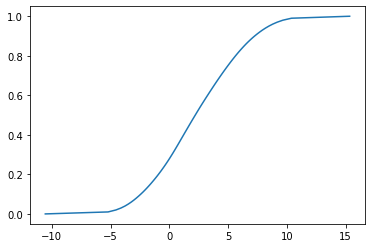

In [105]:
quantiles = xr.open_dataarray(QUANTILES_PATH)
x = quantiles.values[0:]
y = quantiles.quantile_order[0:]
plt.plot(x, y)

In [99]:
obs_all = ['{}_bin_0.0q_{}q'.format(observation, str(np.round(quant + 0.01, 2))) for quant in np.arange(0, 1.0, 0.01)]
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], 'response_lorenz96_rk4_{}_SF_8_1.0_0.nc'.format(obs)))
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())
resp_pred_normal = {}
for obs in obs_all:
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcing_obj)

In [100]:
resp_pred_normal_t50 = [resp_pred_normal[obs][5000] for obs in obs_all]
y_pred_t50 = y + resp_pred_normal_t50
resp_pred_normal_t100 = [resp_pred_normal[obs][9999] for obs in obs_all]
y_pred_t100 = y + resp_pred_normal_t100

#### Plot CDF

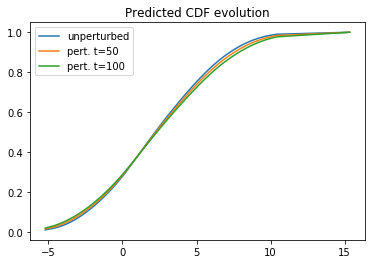

In [101]:
plt.plot(x, y, label='unperturbed')
plt.plot(x, y_pred_t50, label='pert. t=50')
plt.plot(x, y_pred_t100, label='pert. t=100')
plt.title('Predicted CDF evolution')
plt.legend()

if SAVE_PLOT:
    plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_cdf_{}_{}.png'.format(
        obs.replace('.', ''), str(forcing).replace('.', '')
    ))

#### Plot PDF

In [102]:
x_pdf_orig = np.diff(x)/2 + x[:-1]
y_pdf_orig = np.diff(y)/np.diff(x)
y_pdf_t_100 = np.diff(y + resp_pred_normal_t100)/np.diff(x)
y_pdf_t_50 = np.diff(y + resp_pred_normal_t50)/np.diff(x)

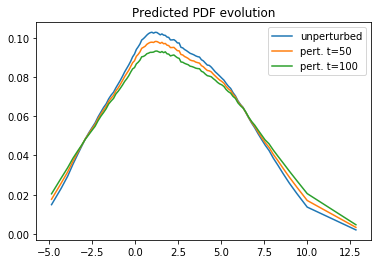

In [103]:
plt.plot(x_pdf_orig, y_pdf_orig, label='unperturbed')
plt.plot(x_pdf_orig, y_pdf_t_50, label='pert. t=50')
plt.plot(x_pdf_orig, y_pdf_t_100, label='pert. t=100')
plt.title('Predicted PDF evolution')
plt.legend()

if SAVE_PLOT:
    plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_pdf_{}_{}.png'.format(
        obs.replace('.', ''), str(forcing).replace('.', '')
    ))

A zoom

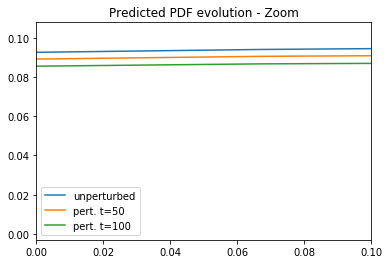

In [104]:
plt.plot(x_pdf_orig, y_pdf_orig, label='unperturbed')
plt.plot(x_pdf_orig, y_pdf_t_50, label='pert. t=50')
plt.plot(x_pdf_orig, y_pdf_t_100, label='pert. t=100')
plt.title('Predicted PDF evolution - Zoom')
plt.legend()
plt.xlim(0,0.1)

if SAVE_PLOT:
    plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_pdf_zoom_{}_{}.png'.format(
        obs.replace('.', ''), str(forcing).replace('.', '')
    ))